# <center> **Coded Apertures: 2D Image Recostruction with GPU Test**<center>

**Libraries**

In [1]:
import torch
import numpy as np
from matplotlib.colors import ListedColormap as lc

import plot_module as plot
import torchmaskpattern as mp
import torchgpucai as cai
from test_torchcodedapertureimaging import TestReconstruction


np.set_printoptions(precision=2, suppress=False)

In [12]:
import importlib
importlib.reload(cai)
importlib.reload(plot)

<module 'plot_module' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_GPUReconstruction_2D/plot_module.py'>

## **2D URA/MURA Masks**

**Sky Simulation**

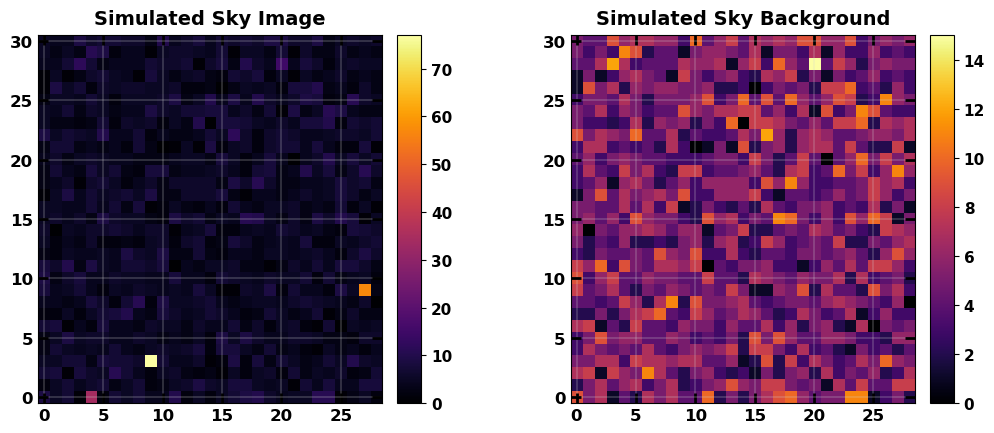

In [2]:
sky_img_shape = mp.URAMaskPattern(4).prime_pair

sources_flux = [30, 50, 70]
sources_pos = [(torch.randint(0, sky_img_shape[0], (1,)).item(), torch.randint(0, sky_img_shape[1], (1,)).item())
               for _ in range(len(sources_flux))]
sky_background_rate = 5

args = (sky_img_shape, sources_flux, sources_pos, sky_background_rate)

sky_image, sky_background = cai.sky_image_simulation(*args)


flag = True

if flag:
    if not sky_background_rate: sky_background = torch.zeros(sky_img_shape)
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"])

### **URA Mask Pattern**

**Sky Reconstruction Simulation**

In [13]:
pattern_type = 'ura'
rank = 20
sources_flux = np.array([30, 50, 70])
mask_padding = True
sky_background_rate = 5
sources_pos = None
detector_background_rate = None
print_info = True

cai_args_ura = (sources_flux, sky_background_rate, sources_pos,
                detector_background_rate, print_info)

use_gpu = True
gpucai = cai.CodedApertureImagingGPU(pattern_type, rank, mask_padding, use_gpu)

detector_image, sky_reconstruction, source_info = gpucai.cai_simulation(*cai_args_ura)
if use_gpu: gpucai._check_gpu_memory()

URA mask realization...
Using GPU...
------------------------------------------------------------------------------------------------------------- 
GPU Memory Usage: | N/A   40C    P8              6W /   80W |    1012MiB /   6144MiB |     16%      Default |
-------------------------------------------------------------------------------------------------------------
GPU: True
Begin CAI pipeline...
Begin CAI reconstruction...
End CAI reconstruction...
Mask pattern type: URA
Basic pattern shape: torch.Size([349, 347])
Mask shape: torch.Size([697, 693])
Decoder shape: torch.Size([697, 693])
Detector image shape: torch.Size([349, 347])
Sky reconstruction image shape: torch.Size([349, 347])
End CAI pipeline...
------------------------------------------------------------------------------------------------------------- 
GPU Memory Usage: | N/A   42C    P8              6W /   80W |     984MiB /   6144MiB |     19%      Default |
-----------------------------------------------------------------

**Mask and Sky Interface**

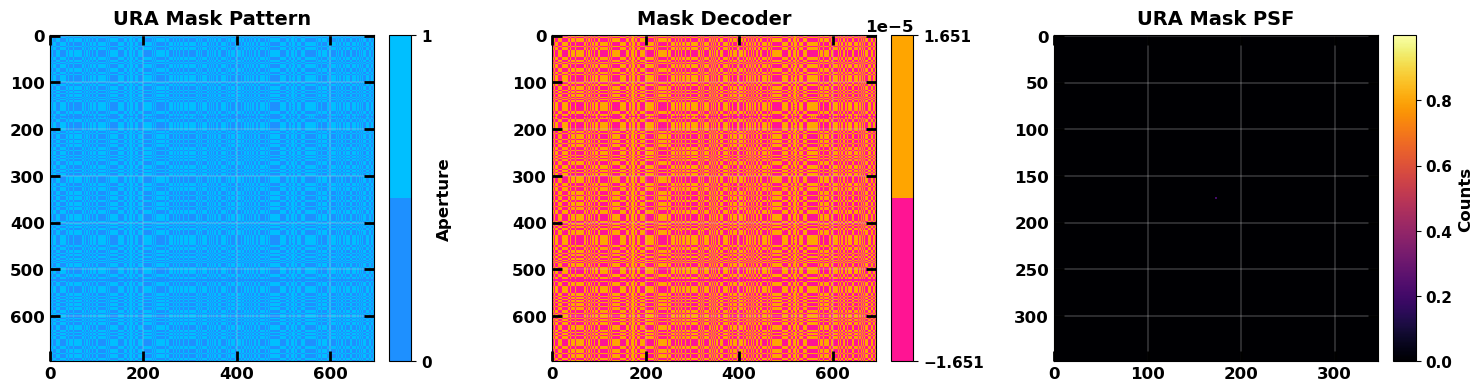

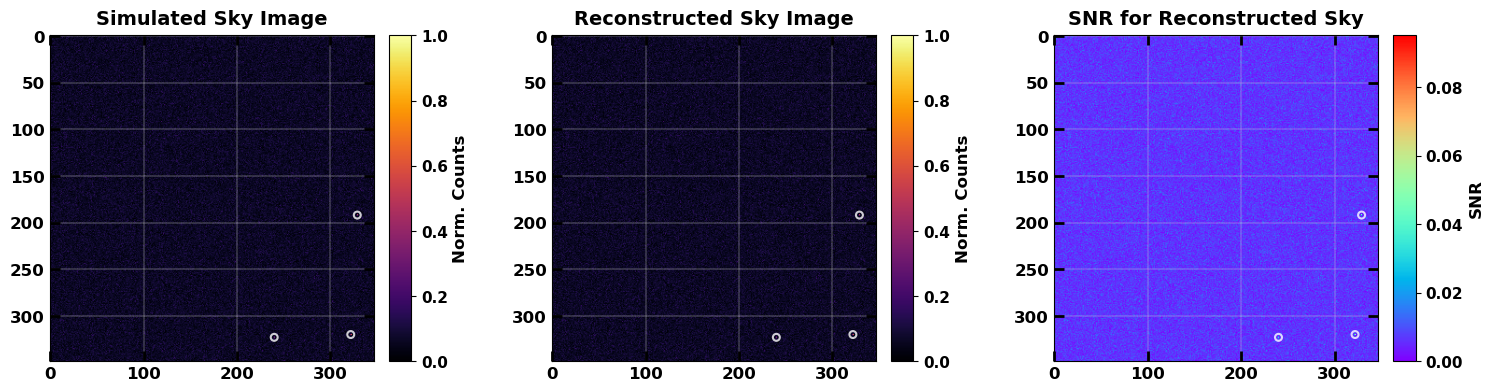

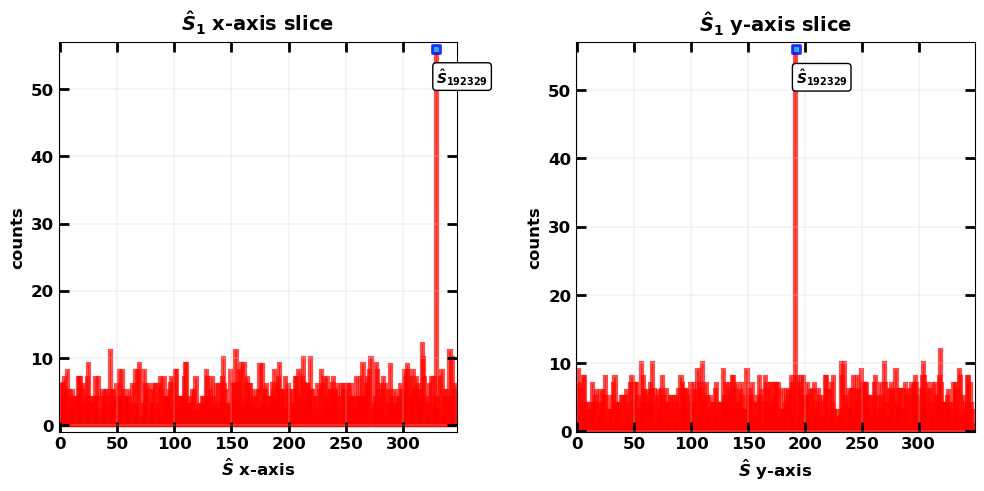

In [14]:
def _normalize(tensor):
    return (tensor - tensor.min())/(tensor.max() - tensor.min())

# plot mask, decoder and PSF
mask = source_info['mask_pattern']
decoder = source_info['mask_decoder']
psf = source_info['mask_PSF']

plot.image_plot([mask, decoder, psf],
                ["URA Mask Pattern", "Mask Decoder", "URA Mask PSF"],
                cbarlabel=["Aperture", None, "Counts"],
                cbarvalues=[[0, 1], [decoder.min(), decoder.max()], None],
                cbarcmap=[lc(["DodgerBlue", "DeepSkyBlue"]), lc(["DeepPink", "Orange"]), "inferno"])

# plot sky image, sky reconstruction and SNR
sky_image = source_info['sky_image']
snr = source_info['sky_reconstruction_SNR']

plot.image_plot([_normalize(sky_image), _normalize(sky_reconstruction), snr],
                ["Simulated Sky Image", "Reconstructed Sky Image", "SNR for Reconstructed Sky"],
                cbarlabel=["Norm. Counts"]*2 + ["SNR"],
                cbarvalues=[None]*3,
                cbarcmap=["inferno"]*2 + ["rainbow"],
                simulated_sources=[source_info['sources_pos']]*3)

# plot reconstr_sky slices
idx = 1
pos = source_info['sources_pos'][idx]
S_hat_slicex = sky_reconstruction[pos[0], :]
S_hat_slicey = sky_reconstruction[:, pos[1]]

plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   xlabel=["$\\hat{{S}}$ x-axis", "$\\hat{{S}}$ y-axis"],
                   ylabel=["counts", "counts"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -5), (pos[0], *pos, -5)])

**Tests**

In [40]:
test_ura = TestReconstruction(pattern_type)
tol = 5

test_ura.test_sky_reconstruction(sky_reconstruction, sky_image, tol)
test_ura.test_sources_reconstruction(source_info['reconstructed_fluxes'], source_info['sky_image_fluxes'], tol)

#### URA Coded Mask Sky Reconstruction Test ####
|S_hat - S| < 5 : True

#### URA Coded Mask Sources Intensity Reconstruction Test ####
|S_hat[0] - S[0]| < 5 : True
|S_hat[1] - S[1]| < 5 : True
|S_hat[2] - S[2]| < 5 : True


tensor([True, True, True])

### **MURA Mask Pattern**

**Sky Reconstruction Simulation**

In [43]:
mpattern_type = 'mura'
mrank = 3
msources_flux = np.array([30, 50, 70])
mmask_padding = True
msky_background_rate = 5
msources_pos = None
mdetector_background_rate = None
mprint_info = True

cai_args_mura = (msources_flux, msky_background_rate, msources_pos,
                 mdetector_background_rate, mprint_info)

use_gpu = True
mgpucai = cai.CodedApertureImagingGPU(mpattern_type, mrank, mmask_padding, use_gpu)
mdetector_image, msky_reconstruction, msource_info = mgpucai.cai_simulation(*cai_args_mura)
mgpucai._check_gpu_memory()

Training on GPU...
------------------------------------------------------------------------------------------------------------- 
GPU Memory Usage: | N/A   40C    P8              6W /   80W |    1297MiB /   6144MiB |      5%      Default |
-------------------------------------------------------------------------------------------------------------
Mask pattern type: MURA
Basic pattern shape: torch.Size([29, 29])
Mask shape: torch.Size([57, 57])
Decoder shape: torch.Size([57, 57])
Detector image shape: torch.Size([29, 29])
Sky reconstruction image shape: torch.Size([29, 29])
------------------------------------------------------------------------------------------------------------- 
GPU Memory Usage: | N/A   40C    P8              6W /   80W |    1297MiB /   6144MiB |      5%      Default |
-------------------------------------------------------------------------------------------------------------


**Mask and Sky Interface**

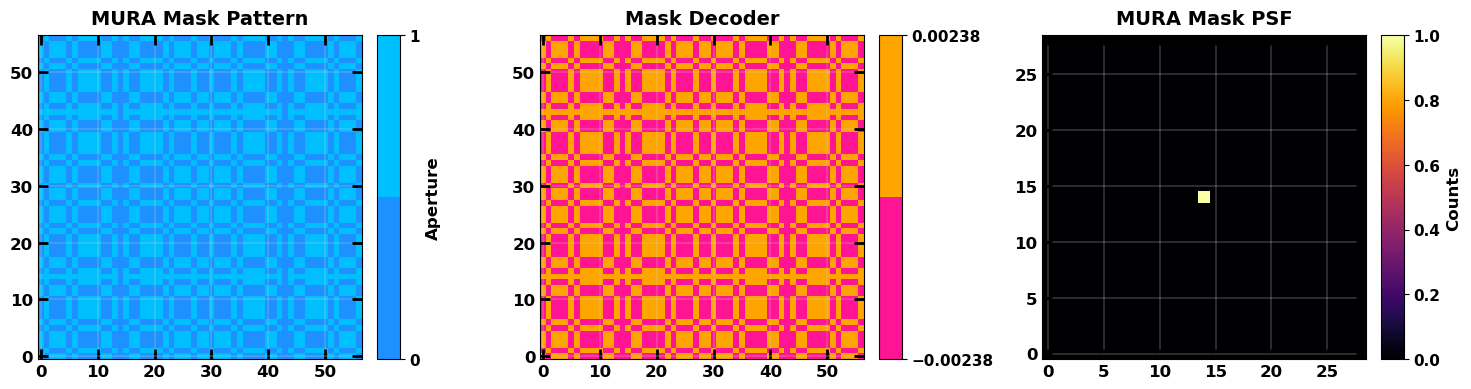

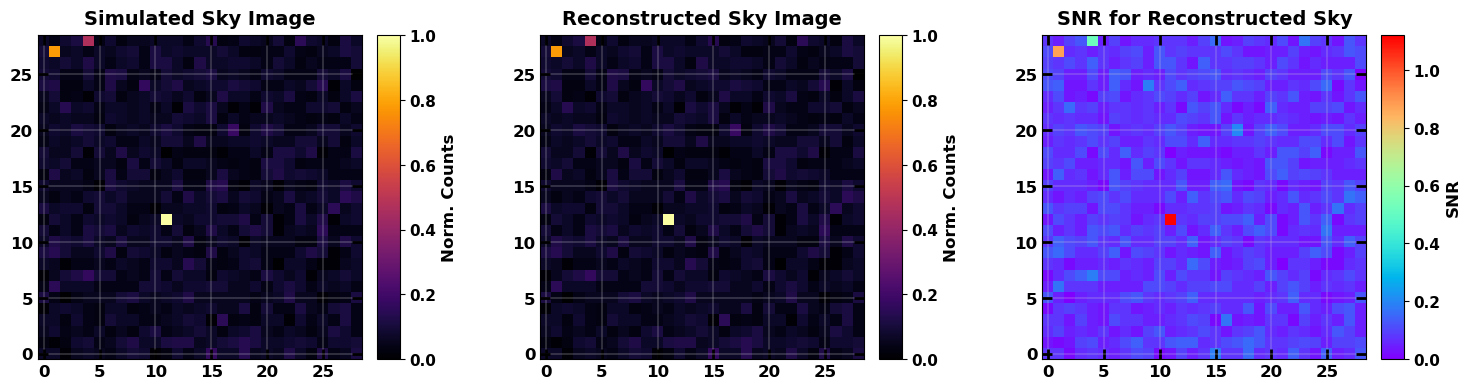

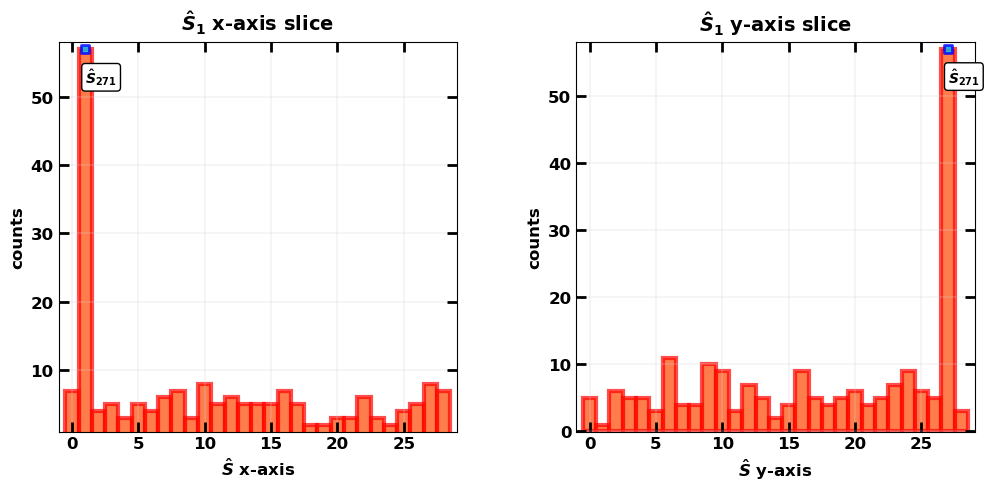

In [48]:
def _normalize(tensor):
    return (tensor - tensor.min())/(tensor.max() - tensor.min())

# plot mask, decoder and PSF
mmask = msource_info['mask_pattern']
mdecoder = msource_info['mask_decoder']
mpsf = msource_info['mask_PSF']

plot.image_plot([mmask, mdecoder, mpsf],
                ["MURA Mask Pattern", "Mask Decoder", "MURA Mask PSF"],
                cbarlabel=["Aperture", None, "Counts"],
                cbarvalues=[[0, 1], [mdecoder.min(), mdecoder.max()], None],
                cbarcmap=[lc(["DodgerBlue", "DeepSkyBlue"]), lc(["DeepPink", "Orange"]), "inferno"])

# plot sky image, sky reconstruction and SNR
msky_image = msource_info['sky_image']
msnr = msource_info['sky_reconstruction_SNR']

plot.image_plot([_normalize(msky_image), _normalize(msky_reconstruction), msnr],
                ["Simulated Sky Image", "Reconstructed Sky Image", "SNR for Reconstructed Sky"],
                cbarlabel=["Norm. Counts"]*2 + ["SNR"],
                cbarvalues=[None]*3,
                cbarcmap=["inferno"]*2 + ["rainbow"],
                simulated_sources=[msource_info['sources_pos']]*3)

# plot reconstr_sky slices
idx = 1
pos = msource_info['sources_pos'][idx]
mS_hat_slicex = msky_reconstruction[pos[0], :]
mS_hat_slicey = msky_reconstruction[:, pos[1]]

plot.sequence_plot([mS_hat_slicex, mS_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   xlabel=["$\\hat{{S}}$ x-axis", "$\\hat{{S}}$ y-axis"],
                   ylabel=["counts", "counts"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -5), (pos[0], *pos, -5)])

**Tests**

In [45]:
test_mura = TestReconstruction(mpattern_type)
tol = 5

test_mura.test_sky_reconstruction(msky_reconstruction, msky_image, tol)
test_mura.test_sources_reconstruction(msource_info['reconstructed_fluxes'], msource_info['sky_image_fluxes'], tol)

#### MURA Coded Mask Sky Reconstruction Test ####
|S_hat - S| < 5 : True

#### MURA Coded Mask Sources Intensity Reconstruction Test ####
|S_hat[0] - S[0]| < 5 : True
|S_hat[1] - S[1]| < 5 : True
|S_hat[2] - S[2]| < 5 : True


tensor([True, True, True])